In [34]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# LSTM model

# Based on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Change to your file path
file_path = '/content/drive/My Drive/Data_Projects/MDS/3rd semester/Deep learning LAB/Assignments/LSTM-time-series-tutorial/data/reframed.csv'
reframed = pd.read_csv(file_path)


In [ ]:
len(reframed)

1412

In [37]:
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
n_train_days = int(0.7 * len(reframed))
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(988, 1, 210) (988,) (424, 1, 210) (424,)


Epoch 1/50
99/99 - 8s - loss: 0.1232 - val_loss: 0.2232 - 8s/epoch - 85ms/step
Epoch 2/50
99/99 - 1s - loss: 0.1270 - val_loss: 0.0943 - 512ms/epoch - 5ms/step
Epoch 3/50
99/99 - 1s - loss: 0.0998 - val_loss: 0.0917 - 623ms/epoch - 6ms/step
Epoch 4/50
99/99 - 1s - loss: 0.0922 - val_loss: 0.0858 - 744ms/epoch - 8ms/step
Epoch 5/50
99/99 - 1s - loss: 0.0854 - val_loss: 0.0889 - 720ms/epoch - 7ms/step
Epoch 6/50
99/99 - 1s - loss: 0.0813 - val_loss: 0.0897 - 688ms/epoch - 7ms/step
Epoch 7/50
99/99 - 1s - loss: 0.0811 - val_loss: 0.0886 - 596ms/epoch - 6ms/step
Epoch 8/50
99/99 - 1s - loss: 0.0762 - val_loss: 0.0889 - 577ms/epoch - 6ms/step
Epoch 9/50
99/99 - 1s - loss: 0.0776 - val_loss: 0.0851 - 613ms/epoch - 6ms/step
Epoch 10/50
99/99 - 1s - loss: 0.0749 - val_loss: 0.0887 - 535ms/epoch - 5ms/step
Epoch 11/50
99/99 - 1s - loss: 0.0729 - val_loss: 0.0839 - 601ms/epoch - 6ms/step
Epoch 12/50
99/99 - 1s - loss: 0.0728 - val_loss: 0.0885 - 809ms/epoch - 8ms/step
Epoch 13/50
99/99 - 1s - lo

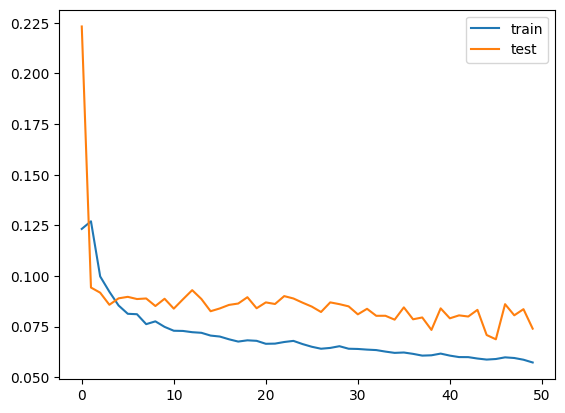

In [38]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:
...
# make a prediction
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
# invert scaling for forecast
inv_yhat = pd.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

TypeError: ignored

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)